# Problem

Reddit is a massive social media platform that differs from the mainstream in the sense it is content-centric, rather than user-centric. Users don’t follow their favorite redditors but instead subscribe to “subreddits” centered around different topics or communities. This leads to all kinds of differences in the content, structure, and culture of Reddit, but like all frameworks, it has its limitations.

One glaring blindspot in this system is that one cannot at a glance see which users are influential. Other social media platforms have follower counts which directly quantify the amount of reach a user is likely to have, while redditors only have karma i.e the net total up and down votes since account creation, and a log of their posts and comments in different subreddits. The two statistics collectively give a rough idea of a user’s activity, but the setup obscures which users are influential in individual subreddits.

Subreddits being the core categories of content aggregation, there is a real problem in understanding where Reddit’s most viewed content comes from. The critical question we hope to answer with this paper is How can we use influencers on Reddit to form a network of related subreddits?

# Process

It has already been found that a very small percentage of Reddit’s users create the vast majority of the site’s content, so we would not be surprised if only a few users could influence the discourse of entire subreddits. Identifying these users would help us understand how Reddit’s “voice” is shaped. We took a top down approach towards analyzing a particular subreddit.

Search a subreddit’s top 500 most upvoted posts of all time
Drill down into these posts and analyze the users who posted
We define ‘influencers’ as those who appeared more than once
Drill down into top submissions by user to find where else do they have influence
Map related subreddits and influencers in a network graph

In [2]:
import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Data Acquisition

The first step before we can draw any kind of insight from a social media platform is acquiring the data itself. We decided to use PRAW - The Python Reddit API Wrapper to meet our needs for grabbing user data from active subreddits. A Reddit account is required to access Reddit’s API. Next, we needed the Client ID and Client Secret to access Reddit’s API as a script application. Reddit’s documentation on their First Steps Guide to generate keys walks you through the process.

For our needs to scrape data, we needed a Read-Only instance of Reddit using PRAW. To create a read-only Reddit instance, we also needed a user agent which is a unique identifier that helps Reddit determine the source of network requests.

Next, we wrote a function to fetch a particular number of posts in a subreddit. get_posts takes two parameters, sub_name and n, it returns a Pandas data frame comprised of a list of top n posts in a subreddit. We store each post’s id, score (net score of upvotes and downvotes), number of comments and the subreddit it was made in. For the purposes of our initial analysis, we picked r/marvelstudios, a subreddit focussed on the Marvel cinematic universe content.

In [3]:
# Authentication-Setting up the Reddit API in python
reddit = praw.Reddit(client_id='85l9bZnfpIYGWw',
                        client_secret='3kfGTZV-dUKSB-A7IMxepHkLLEL9XA',
                        user_agent='Due-Ad-3957')

In [ ]:
Data Pre-procesing

In order to ensure our data was free of any discrepancies, we cleaned any null (deleted) users that made the top posts in a subreddit. We gathered the repeating posters who made it to the top posts of all time in a subreddit and cleaned that data frame of any null values.

In [3]:
# Define functions for future data scraping 

In [4]:
def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

In [5]:
def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df   

In [6]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df 

# Exploratory Analysis of r/all

In [7]:
# First we scrape 1000 posts, then using submission id, scrape most popular comments of every post and append it to the 
# dataframe with comments 
df = get_posts('all', 1000)

In [8]:
df.shape # Explore posts dataframe

(1000, 5)

In [9]:
df.head(10)

,id,score,author,num_comments,subreddit
0,haucpf,438836,ReallyRickAstley,19324,pics
1,l8rf4k,412180,SomeGuyInDeutschland,12457,wallstreetbets
2,jptqj9,365115,throwawaynumber53,29019,news
3,62sjuh,349288,serventofgaben,4500,movies
4,l6wu59,315203,vrweensy,12836,wallstreetbets
5,7mjw12,307856,the_Diva,2449,funny
6,gyfedz,303727,rextraneous,3066,memes
7,5gn8ru,283475,iH8myPP,4952,funny
8,88ll08,281750,patientbearr,11315,videos
9,l78uct,280707,DeepFuckingValue,23701,wallstreetbets


In [10]:
df.author.nunique()

875

In [11]:
df.subreddit.nunique()

60

In [12]:
df['score'].describe()

count      1000.000000
mean     171230.897000
std       28809.298424
min      143317.000000
25%      152610.000000
50%      162328.000000
75%      179398.250000
max      438836.000000
Name: score, dtype: float64

In [13]:
df['num_comments'].describe()

count     1000.000000
mean      3827.766000
std       5005.648092
min          2.000000
25%       1412.000000
50%       2343.000000
75%       4343.500000
max      83257.000000
Name: num_comments, dtype: float64

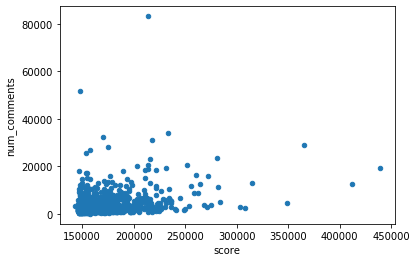

In [14]:
df.plot('score', 'num_comments', kind = 'scatter' )

# Exploratory Analysis based on a r/wallstreetbets

Part 1
Analyzing the top 500 posts of all time on r/wallstreetbets revealed some interesting insights about Reddit posts. In figure 1, the scatter plot shows that the number of comments don’t necessarily increase with posts that have a higher net score.

In [17]:
import matplotlib.pyplot as plt

In [18]:
marvel_df = get_posts('wallstreetbets', 500) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [20]:
marvel_df.author.nunique() # Out of 500, 434 are unique 

435

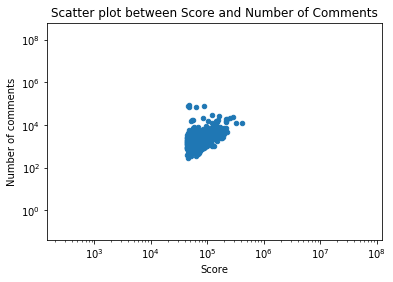

In [21]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

The number of comments stays fairly unchanged in the range of posts scores of 20,000 and 60,000. Our initial hypothesis was to see a directly proportional relationship between the number of comments and score. We observed a similar scatter plot for r/all on a larger scale.

Part 2
Next, we analyzed recurring users whose posts made it to the top 500 of all time. We found that only 13% of the users appeared more than once on the top posts of r/marvelstudios. We are led to believe it varies by a given subreddit. Following our process from Section 2, we scraped the top 10 posts of every user. We made a bar graph of number of submissions made by recurring users in r/marvelstudios

Our definition of an Influencer came from analyzing this bar graph. We realized that the cut-off for being influencer each subreddit would be subjective to the size of the subreddit and how often submissions are made. The cut-off we decided for this particular subreddit was 2 or more submissions in top posts of all time.

In [22]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [23]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [24]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

24

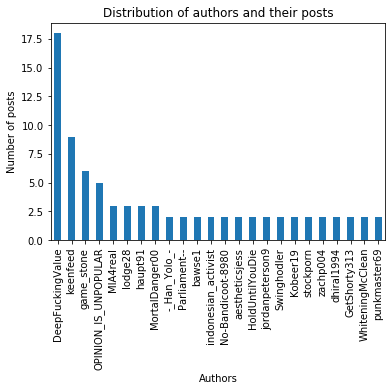

In [25]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [26]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [27]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [29]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [30]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

,id,score,author,num_comments,subreddit
0,l78uct,280718,DeepFuckingValue,23701,wallstreetbets
1,l846a1,251860,DeepFuckingValue,20585,wallstreetbets
2,lnqgz8,216094,DeepFuckingValue,13215,wallstreetbets
3,l6ekdz,211058,DeepFuckingValue,15199,wallstreetbets
4,lae6j0,210685,DeepFuckingValue,18700,wallstreetbets
5,m0q5bm,165460,DeepFuckingValue,8288,wallstreetbets
6,lb6jld,155100,DeepFuckingValue,17395,wallstreetbets
7,msblc3,145382,DeepFuckingValue,13708,wallstreetbets
8,lt7v4w,145219,DeepFuckingValue,7904,wallstreetbets
9,lbykxg,142730,DeepFuckingValue,10262,wallstreetbets


Part 3
Next, we analyzed where else did these top posters had influence by compiling a list of authors that appeared more than once on other subreddits. In order to form a network graph, we needed data about the particular subreddits where our influencers appeared. For the sake of simplicity, we visualized those subreddits with at least 2 or more posts made by the influencers. The Y-axis is the number of submissions and the X-axis are the respective subreddits.

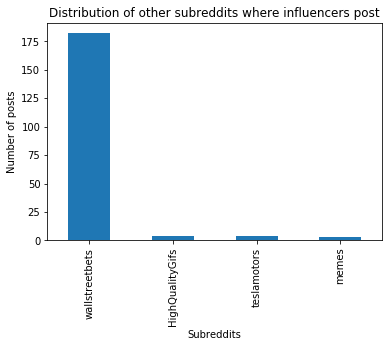

In [31]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [32]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

,author,subreddit
0,DeepFuckingValue,wallstreetbets
1,DeepFuckingValue,wallstreetbets
2,DeepFuckingValue,wallstreetbets
3,DeepFuckingValue,wallstreetbets
4,DeepFuckingValue,wallstreetbets


C:\Users\thomp\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\thomp\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


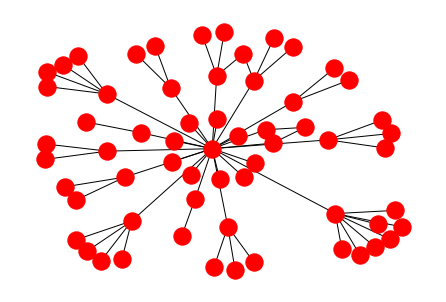

In [33]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Building the Model

One of the challenges we faced was visualizing the data we had acquired in a network graph. It was an interesting change of dynamic from thinking about data the form of rows and columns to nodes and edges.

We decided we needed to use a more standardized approach so we used the spring layout NetworkX has to offer. In order to have some form of convention, we decided to draw the edges thin and grey. Influencer nodes appear small and grey. Meanwhile, the subreddits appear in blue and sized according to their respective number of connections. To keep things tidy, we only labeled the subreddits. Finally, the influencers who have more connections than just r/marvelstudios are highlighted in yellow.

In [34]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

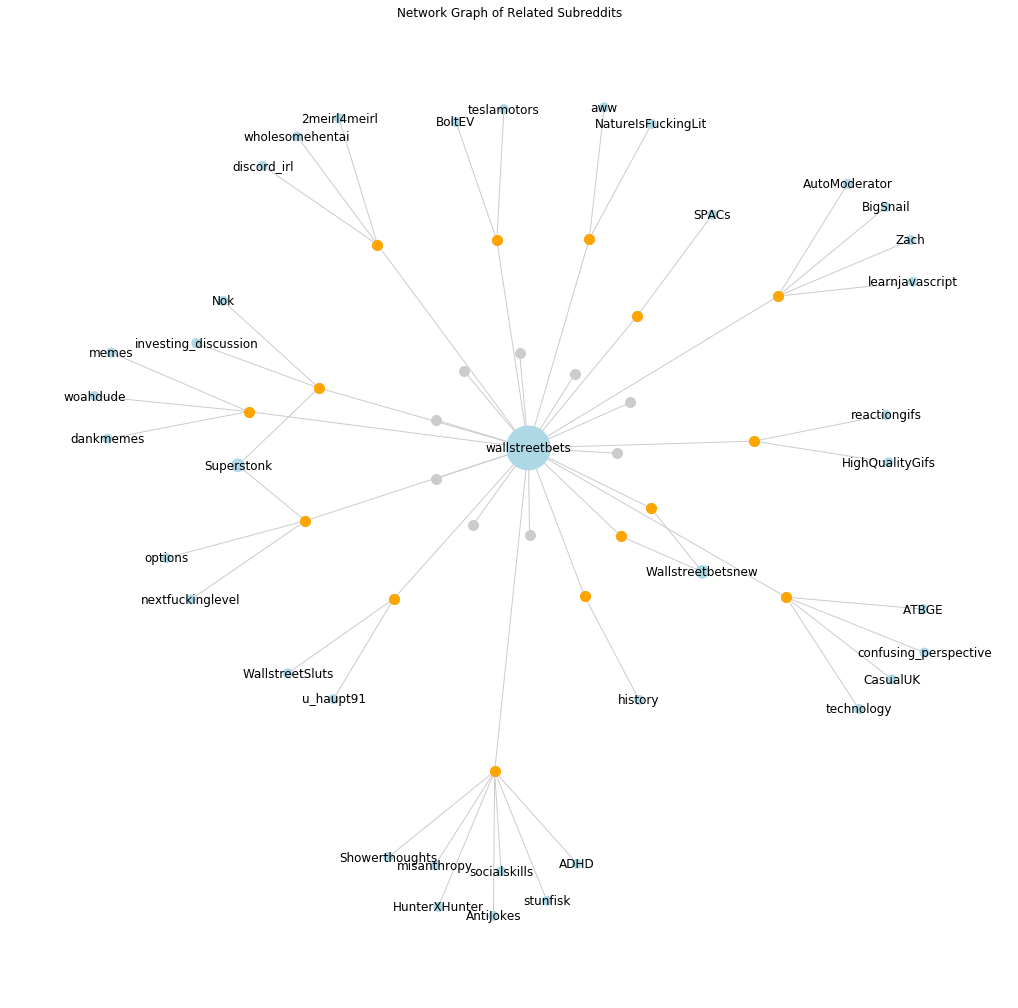

In [35]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [36]:
g.degree('wallstreetbets') # To check the number of out-degrees for a subreddit, if interested 

24

# Stock Predictions using r/wallstreetbets

In [38]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from pprint import pprint
import praw

In [39]:

headlines=set()
for sub in reddit.subreddit('wallstreetbets').new(limit=None):
    headlines.add(sub.title)
print(len(headlines))

786


In [42]:
sia = SIA()
results=[]
for line in headlines:
    scores = sia.polarity_scores(line)
    scores['headlines']=line
    results.append(scores)
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,headlines
0,0.424,0.576,0.000,-0.7096,Taiwan Stock Crash Shows World Dangers of Too ...
1,0.162,0.838,0.000,-0.4019,Not being the only one to lose money this mont...
2,0.492,0.508,0.000,-0.4404,Did Vlad do a perjury?
3,0.000,0.676,0.324,0.3382,"AG Yolo update 5/7, Let’s go!"
4,0.000,1.000,0.000,0.0000,"Daily Discussion Thread for May 11, 2021"


In [43]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import praw
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import numpy as np

In [44]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\thomp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thomp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [53]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import praw
import nltk

In [54]:
from numpy.core.defchararray import rstrip

global selectedTickerSymbolCount
global selectedTickerSymbol
selectedTickerSymbolCount = 0


In [55]:
selectedTickerSymbol = 'GME'
selectedsubreddit = 'wallstreetbets'

In [56]:
howmanysumbissions = 25000


In [57]:
# get x number of top posts from the subreddit
top_posts = reddit.subreddit(selectedsubreddit).top('month', limit=howmanysumbissions)


In [58]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [59]:
sia = SentimentIntensityAnalyzer()

In [60]:
# Sentiment analysis function for TextBlob tool
def text_blob_sentiment(review, sub_entries_textblob):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity >= 0.0001:
        if analysis.sentiment.polarity > 0:
            sub_entries_textblob['positive'] = sub_entries_textblob['positive'] + 1
            return 'Positive'

    elif analysis.sentiment.polarity <= -0.0001:
        if analysis.sentiment.polarity <= 0:
            sub_entries_textblob['negative'] = sub_entries_textblob['negative'] + 1
            return 'Negative'
    else:
        sub_entries_textblob['neutral'] = sub_entries_textblob['neutral'] + 1
        return 'Neutral'



In [61]:
# sentiment analysis function for VADER tool
def nltk_sentiment(review, sub_entries_nltk):
    vs = sia.polarity_scores(review)
    if not vs['neg'] > 0.05:
        if vs['pos'] - vs['neg'] > 0:
            sub_entries_nltk['positive'] = sub_entries_nltk['positive'] + 1
            return 'Positive'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'

    elif not vs['pos'] > 0.05:
        if vs['pos'] - vs['neg'] <= 0:
            sub_entries_nltk['negative'] = sub_entries_nltk['negative'] + 1
            return 'Negative'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'
    else:
        sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
        return 'Neutral'


In [62]:
# replication of comment section of reddit post
def replies_of(top_level_comment, count_comment, sub_entries_textblob, sub_entries_nltk):
    global selectedTickerSymbolCount
    if len(top_level_comment.replies) == 0:
        count_comment = 0
        return
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                count_comment += 1
                # print('-' * count_comment, comment.body)
                text_blob_sentiment(comment.body, sub_entries_textblob)
                nltk_sentiment(comment.body, sub_entries_nltk)

                # Search for stock ticker symbol in comment body and increment counter if found
                if comment.body.find(selectedTickerSymbol) != -1:
                    selectedTickerSymbolCount += 1
            except:
                continue
            replies_of(comment, count_comment, sub_entries_textblob, sub_entries_nltk)


In [63]:
def main():
    # global int for recording how many times the program finds the stock ticker in the reddit comments
    # i only wanted to extract records with a mention of the selected stock. I also will pull that number into my model
    # as a feature.

    # creates empty pandas dataframe, which will be filled with data from the reddit comments as the program runs
    global selectedTickerSymbolCount
    commentDF = pd.DataFrame()

    # this creates a data frame called 'hist' and fills it with stock data for the selected stock. I am taking
    # all the data as there are less than 10,000 records. It then prints the data set.
    selectedTicker = yf.Ticker(selectedTickerSymbol)
    hist = selectedTicker.history(period="max")
    print('\n')
    print('\n')
    print('\n')
    print(hist)
    
    
    # loop through the submissions
    submissioncounter = 1
    for submission in top_posts:
        sub_entries_textblob = {'negative': 0, 'positive': 0, 'neutral': 0}
        sub_entries_nltk = {'negative': 0, 'positive': 0, 'neutral': 0}
        print('Submission:', submissioncounter,'   |  Title of the post :', submission.title)
        submissioncounter = submissioncounter + 1
        text_blob_sentiment(submission.title, sub_entries_textblob)
        nltk_sentiment(submission.title, sub_entries_nltk)
        # print("\n")
        submission_comm = reddit.submission(id=submission.id)

        for count, top_level_comment in enumerate(submission_comm.comments):
            # print(f"-------------{count} top level comment start--------------")
            count_comm = 0
            try:
                # print(top_level_comment.body)
                text_blob_sentiment(top_level_comment.body, sub_entries_textblob)
                nltk_sentiment(top_level_comment.body, sub_entries_nltk)
                replies_of(top_level_comment,
                           count_comm,
                           sub_entries_textblob,
                           sub_entries_nltk)
            except:
                continue

    # fetching the Unix timestamp from the comment
        unix_time = submission_comm.created_utc
        commentPostedUnixTime = str(datetime.fromtimestamp(unix_time))
        commentYMD = commentPostedUnixTime[0:11:1]

        # get the senitment values. These are from a dictionary so have to be access via the key
        # and then array location. The code uses both textblob and vader.
        textblobnegative = sub_entries_textblob.get('negative',0)
        textblobpositive = sub_entries_textblob.get('positive',0)
        textblobneutral = sub_entries_textblob.get('neutral',0)

        vadernegative = sub_entries_nltk.get('negative',0)
        vaderpositive = sub_entries_nltk.get('positive',0)
        vaderneutral = sub_entries_nltk.get('neutral',0)

        # if the program finds 1 or more mentions of the stock ticker in the comments, then it will record that record
        # and append it to the data set
        if selectedTickerSymbolCount > 0:

            commentYMD = commentYMD.rstrip()
            commentYMD = datetime.strptime(commentYMD, '%Y-%m-%d')
            rowsToAppend = {'Title': submission.title, 'Ticker': selectedTickerSymbol, 'Date': commentYMD,
                            'NumberOfTickerMentions': selectedTickerSymbolCount, 'Vader Neg': vadernegative,
                            'Vader Pos': vaderpositive, 'Vader Neut': vaderneutral, 'textblob Negative': textblobnegative
                            , 'textblob Positive': textblobpositive, 'textblob Neut': textblobneutral}
            commentDF = commentDF.append(rowsToAppend, ignore_index = True)
            selectedTickerSymbolCount = 0
            # reset the counter that records how many times the stock symbol is found in the comments


    # export the files as a .csv
    # comment_analysis: this has the results of the sentiment analysis
    # stockticker_history: this has the extract of the stock price information for the selected stock

    commentDF.to_csv(r'comment_analysis.csv', index=False, header=True)
    hist.to_csv(r'stockticker_history.csv', index=True,header=True)
    print('\n')
    print('Sentiment analysis is below:')
    print('\n')
    print(commentDF)
    print('\n')
    print('Process complete. Files have been saved.')
if __name__ == '__main__':
    main()

            
            
            
            







                  Open        High         Low       Close    Volume  \
Date                                                                   
2002-02-13    6.480513    6.773399    6.413183    6.766666  19054000   
2002-02-14    6.850831    6.864296    6.682506    6.733003   2755400   
2002-02-15    6.733001    6.749833    6.632006    6.699336   2097400   
2002-02-19    6.665671    6.665671    6.312189    6.430017   1852600   
2002-02-20    6.463681    6.648838    6.413183    6.648838   1723200   
...                ...         ...         ...         ...       ...   
2021-05-10  161.309998  161.589996  143.000000  143.220001   4806700   
2021-05-11  137.000000  150.500000  136.500000  146.919998   4684600   
2021-05-12  145.699997  150.500000  142.229996  144.789993   2731500   
2021-05-13  147.440002  169.949997  146.429993  164.500000   8860800   
2021-05-14  147.440002  166.470001  156.220001  159.919998   4248632   

            Dividends  Stock Splits  
Date               

Submission: 82    |  Title of the post : Ran into this at work. To the moon!
Submission: 83    |  Title of the post : AMC CEO PLEDGES AND WILL FILE THAT THEY WILL NOT SELL A SINGLE SHARE OF THE POTENTIAL NEW 500 MILLION AMC SHARES ISSUED
Submission: 84    |  Title of the post : Rare copy of: Melvil, Citadels and the medias bible.
Submission: 85    |  Title of the post : MindMed to be listed on Nasdaq! Time for a trip to the Moon 🍄🚀
Submission: 86    |  Title of the post : 143k Yolo on MVIS. Down 50% so you know it’s good.
Submission: 87    |  Title of the post : Spongebob's Take on GME
Submission: 88    |  Title of the post : How I imagine a weekend meeting between Melvin and Citadel:
Submission: 89    |  Title of the post : All in #GME
Submission: 90    |  Title of the post : shout out to u/meiggs who accidentally bought 50k worth of GMED a month ago and is now up more than 15%
Submission: 91    |  Title of the post : 'COIN' gifted $25,000 in stocks to all 1700 employees ahead of IPO


Submission: 163    |  Title of the post : To the Guy who decided to Short the country of South Africa
Submission: 164    |  Title of the post : 240k CLOV YOLO
Submission: 165    |  Title of the post : Postponing my marriage and house purchase. Thank you $PLTR and $DMTK. 🤡
Submission: 166    |  Title of the post : Robinhood was paid over $330 million for order flow
Submission: 167    |  Title of the post : Bill Gates liquidating stock in the form of divorce
Submission: 168    |  Title of the post : I aped all my money into COIN, can I join your retard club?
Submission: 169    |  Title of the post : NVIDIA YOLO lets gooo not bad for one month
Submission: 170    |  Title of the post : 1MM if $GME hits $1100 on Friday 😀
Submission: 171    |  Title of the post : MindMed ($MNMD) CEO on going public: “But at the end of the day, people make markets.”
Submission: 172    |  Title of the post : I'd like an order of GME tendies with a side of GME thetagang tendies
Submission: 173    |  Title of th

Submission: 243    |  Title of the post : See I’m smart I picked contracts 1 week after DFVs expiration so I can lose even more money 💪
Submission: 244    |  Title of the post : CLOV - Over $1M In and I’m Not Going Anywhere
Submission: 245    |  Title of the post : MindMed ($MNMD) and the upcoming Psychedelics #ShroomBoom 🍄
Submission: 246    |  Title of the post : GameStop Victories Now Include S&P Credit Upgrade (B Rating)
Submission: 247    |  Title of the post : Urasawa's Investor
Submission: 248    |  Title of the post : The Lucky Clover 🍀
Submission: 249    |  Title of the post : Made a bit off apple and put some back into game stop. We at this side of the world is all for GME.
Submission: 250    |  Title of the post : DD: GME Implied Volatility Update - Trend is Lower
Submission: 251    |  Title of the post : I, too, YOLO'D my retirement account into GME when I switched jobs. PICK ME UP ON THE WAY TO THE MOON PLS
Submission: 252    |  Title of the post : When you’re desperately 

Submission: 315    |  Title of the post : My entire life's worth is in these calls
Submission: 316    |  Title of the post : YOLO'd my whole account into $CVS after my DD from a few weeks ago. This is how that's going
Submission: 317    |  Title of the post : Decided to start selling GME puts, here's how the first 2 weeks went
Submission: 318    |  Title of the post : It’s official. I’m retarded. While attempting to sell 150 calls on $CLOV I accidentally bought 150 may $25 calls today near the high like an idiot. Need your help with this one boys $CLOV guess I’ll chalk this one up as a YOLO
Submission: 319    |  Title of the post : MNMD FALL IN!!
Submission: 320    |  Title of the post : SEC chronicles: Shitadel
Submission: 321    |  Title of the post : It’s great working with you guys ruining my life.
Submission: 322    |  Title of the post : MMA Fighter from tonight’s Bellator event clearly holds! 💎👊💎👊
Submission: 323    |  Title of the post : First time poster - $39K GME YOLO. Feels

Submission: 398    |  Title of the post : MVIS $172k YOLO
Submission: 399    |  Title of the post : Being a little late on a WSB DD
Submission: 400    |  Title of the post : MicroVision Q1 Results Moved Up to April 29th 2021
Submission: 401    |  Title of the post : LFG!
Submission: 402    |  Title of the post : DD and SWOT Analysis on MindMed ($MNMD), a Psychedelic-based, Clinical-stage Pharma Company Applying LSD to Mental Health
Submission: 403    |  Title of the post : Nokia is extremely undervalued at current prices
Submission: 404    |  Title of the post : $NOK is super undervalued
Submission: 405    |  Title of the post : Why is $MNMD actually in red for many people?
Submission: 406    |  Title of the post : (O.C.) Keep shorting GME 🤡
Submission: 407    |  Title of the post : Ladies and Apes: MINDMED🚀🚀🚀 to NASDAQ
Submission: 408    |  Title of the post : I'm buying WY and so should you.
Submission: 409    |  Title of the post : CLOV Stock Busts Through Resistance BULLISH .
Submi

Submission: 482    |  Title of the post : 180K position in $INO (Inovio) upcoming positive catalyst next 9 days. Multibagger potential.
Submission: 483    |  Title of the post : Last dip that I could afford I guess I will forever be a bag holder 🤡
Submission: 484    |  Title of the post : Do financial websites just make up reasons why stocks go up or down after the fact?
Submission: 485    |  Title of the post : $COIN: $150B ($570/share) Price Target
Submission: 486    |  Title of the post : TSLA YOLO to mars
Submission: 487    |  Title of the post : $AMC 🎥 🎥🎥 HOT GIRL 👯👯👯 SUMMER AROUND THE CORNER! BOX OFFICE GRO$$E$ 💰💰💰 HEATING UP 🔥🔥🔥
Submission: 488    |  Title of the post : $33,000 in 10 minutes. $TSLA FD gainz
Submission: 489    |  Title of the post : I love PLTR
Submission: 490    |  Title of the post : Time for you apes to grow your first wrinkle. Why I think a cucked generation of millenials will blow RKT's ER on May 5th to Uranus
Submission: 491    |  Title of the post : BlackB

Submission: 559    |  Title of the post : Played TSLA heavy after January. F’s in the chat for buying the top and trying to catch that falling knife...
Submission: 560    |  Title of the post : AMD: An explanation on merger arbitrage and how to play it for big gains
Submission: 561    |  Title of the post : What Are Your Moves Tomorrow, April 22, 2021
Submission: 562    |  Title of the post : RKT YOLLOOOO ALL INNNNNN WHOS WITH ME
Submission: 563    |  Title of the post : PLTR - LOVE THE COMPANY / HATE THE SHORT TERM STONK
Submission: 564    |  Title of the post : JPMorgan to finance the launch of European Premier league
Submission: 565    |  Title of the post : Daily Discussion Thread for May 11, 2021
Submission: 566    |  Title of the post : CLOV - Some Option Information
Submission: 567    |  Title of the post : MNMD 100k YOLO 🍄🚀
Submission: 568    |  Title of the post : 30k YOLO $MNMD THE FUTURE IS HERE APES 🦍🦍🦍
Submission: 569    |  Title of the post : One stock
Submission: 570    

Submission: 640    |  Title of the post : AMC YOLO UPDATE : 4448 SHARES, 8 CALLS, across 4 accounts -- still bullish 🐂
Submission: 641    |  Title of the post : YOLO Update. 2301 more shares on my second brokerage account. To the moon we go!
Submission: 642    |  Title of the post : Suncor (SU) update. They crushed earnings. Please don’t be too jealous of my gains today.
Submission: 643    |  Title of the post : Biden to Propose Tax Hikes, $80 Billion for Audits of Rich
Submission: 644    |  Title of the post : I’m just here to sightsee on the way to the moon
Submission: 645    |  Title of the post : WSB Leveraged Smart-Beta Update (Now Up +$350K, +108%)
Submission: 646    |  Title of the post : Everytime PLTR I think you are cool then you show me.. KO life savings
Submission: 647    |  Title of the post : Daily Discussion Thread for April 22, 2021
Submission: 648    |  Title of the post : MVIS- continuing on this mvis Yolo game with the 💎hands. The moon is gone be lit. I love this sto

Submission: 716    |  Title of the post : Am I diversified? It wasn't all purchased in the same day.
Submission: 717    |  Title of the post : RKT YOLT. Doubling down with gains from the last ER. Still in the process of building the position. Earnings on May 5.
Submission: 718    |  Title of the post : Tired of losing money so I switched from calls to puts... ended up being a good time to do that
Submission: 719    |  Title of the post : This is my 90% of portfolio...Only possible with some Miracle 😢..Lesson Learnt with 6 Months of My savings 😔...Have to accept Greed always kills 🤕
Submission: 720    |  Title of the post : RKT earnings options play
Submission: 721    |  Title of the post : Battleground ? It’s a mothaf’in WAR. MVIS ✋💎💎💎💎💎🤚
Submission: 722    |  Title of the post : Made 700k in GME in Jan. Then did this
Submission: 723    |  Title of the post : Papers hands, probably.
Submission: 724    |  Title of the post : It was a gUhd day to be all in PLTR
Submission: 725    |  Titl

Submission: 798    |  Title of the post : Blackberry's patent value and overnight stock to $40
Submission: 799    |  Title of the post : AMD's fundamentals in charts, time to rise!
Submission: 800    |  Title of the post : Bots are off! Get your shitposting in while you can!
Submission: 801    |  Title of the post : Huge pu$$y retard checking in. Late to the party. Pretty much content with half of my portfolio being gone come Monday. Feels bad man.
Submission: 802    |  Title of the post : Spell RED
Submission: 803    |  Title of the post : Where all my travel sector degenerates? We going to the Bahamas bois
Submission: 804    |  Title of the post : UWMC- 12% gained back this week. Pre earning run up still going to happen next week. Sleeping giant waiting to explode in my opinion. Russel inclusion- may 7th And earnings may 10th.
Submission: 805    |  Title of the post : VIAC massively undervalued right now and has had an amazing earnings report
Submission: 806    |  Title of the post :

Submission: 876    |  Title of the post : MVIS up 25% today
Submission: 877    |  Title of the post : Money printer go BRRRR next week? 🤑
Submission: 878    |  Title of the post : Per Request: RKT 630k YOLO Update.. Earningss INCOMMINNGGG!!
Submission: 879    |  Title of the post : My 401k vs My “investing” account
Submission: 880    |  Title of the post : $RKT May 5 earnings YOLO
Submission: 881    |  Title of the post : pLTR I deserve to be here
Submission: 882    |  Title of the post : MNMD YOLO
Submission: 883    |  Title of the post : PSFE looks relatively undervalued. Guess I’ll throw some dollars at it
Submission: 884    |  Title of the post : Is $PLTR really that good of a buy?
Submission: 885    |  Title of the post : RKT = A moment of silence -_-
Submission: 886    |  Title of the post : My fellow PLTR apes should know the risks
Submission: 887    |  Title of the post : BLIE SKIES COMING. NIO the new leader
Submission: 888    |  Title of the post : Loss porn $RIDE Feels good 

Submission: 956    |  Title of the post : [UPDATE] YOLO $NIO $39 calls 8/20, 93 contracts. Currently up +$16,089.00. Still holding strong.
Submission: 957    |  Title of the post : I’m probably the biggest $BB bull and made a big bet only for it to become absolutely worthless. options down 90% but i’m hoping for a comeback. hopefully we will breakout of the bearish pattern. this truly is a turnaround story!!!!
Submission: 958    |  Title of the post : Inovio is worth looking into ($INO)
Submission: 959    |  Title of the post : Adding another $20k to my 🌈 🐻 TSLA position.
Submission: 960    |  Title of the post : DD My Fat Ex-wife edition - Becky Stocks - Etsy - Down 5% April 30th, not going to stay down.
Submission: 961    |  Title of the post : $NIO new Buy at CLSA, PT $50
Submission: 962    |  Title of the post : CLOV YOLO UPDATE - Added $24k more in options contracts. Today was GUH but with a little luck, I'll be driving a Lambo instead of needing a bus pass.
Submission: 963    |  

In [64]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
df_redditcomments = pd.read_csv('../input/wsb-gme-reddit-submission-vs-stock-price/comment_analysis.csv')
df_stockdata = pd.read_csv('../input/wsb-gme-reddit-submission-vs-stock-price/stockticker_history.csv')